In [49]:
setwd('/import/DB/fel/BJTC-204')

In [50]:
#data = read.csv('./TOD.rela.2.csv',row.names = 1)

In [51]:
load('./exp4.rda')

In [52]:
ls()

[1] "MDD"             "contrast.matrix" "death"           "death2"         
 [5] "desigN"          "diff"            "exp4"            "expr"           
 [9] "expr1"           "f"               "fit"             "fit2"           
[13] "gene1"           "matrix"          "tempOutput"      "tempOutput1"    
[17] "top_5"

In [53]:
library(dplyr)

In [54]:
dim(exp4)

[1]   251 11882

In [55]:
MDD = exp4 %>%   dplyr::filter(TYPE == 'MDD')
table(MDD$death)


 0  1 
35 41 

In [56]:
death = MDD$death
MDD$GSM

[1] "GSM2431728" "GSM2431731" "GSM2431735" "GSM2431751" "GSM2431755"
 [6] "GSM2431758" "GSM2431763" "GSM2431787" "GSM2431788" "GSM2431792"
[11] "GSM2431795" "GSM2431807" "GSM2431812" "GSM2431814" "GSM2431828"
[16] "GSM2431832" "GSM2431835" "GSM2431840" "GSM2431842" "GSM2431871"
[21] "GSM2431878" "GSM2431879" "GSM2431914" "GSM2431920" "GSM2431921"
[26] "GSM2431936" "GSM2431941" "GSM2431946" "GSM2431951" "GSM2431977"
[31] "GSM2431978" "GSM2431983" "GSM2431987" "GSM2432001" "GSM2432004"
[36] "GSM2432007" "GSM2432008" "GSM2432020" "GSM2432023" "GSM2432026"
[41] "GSM2432027" "GSM2432033" "GSM2432035" "GSM2432036" "GSM2432075"
[46] "GSM2432085" "GSM2432086" "GSM2431843" "GSM2431858" "GSM2431971"
[51] "GSM2432037" "GSM2432052" "GSM2431748" "GSM2431754" "GSM2431770"
[56] "GSM2431782" "GSM2431802" "GSM2431866" "GSM2431867" "GSM2431876"
[61] "GSM2431900" "GSM2431907" "GSM2431925" "GSM2431933" "GSM2431940"
[66] "GSM2431944" "GSM2431958" "GSM2431959" "GSM2431969" "GSM2431970"
[71] "GSM2431995" "GSM2432065" "GSM2432068" "GSM2432070" "GSM2432077"
[76] "GSM2432081"

In [57]:
expr = exp4[MDD$GSM,8:11882]
colnames(expr) = gsub('-','.',colnames(expr))
expr <- expr[, !grepl("^\\d+", names(expr))]

In [58]:
expr1 = expr%>%  t() %>%  as.data.frame()

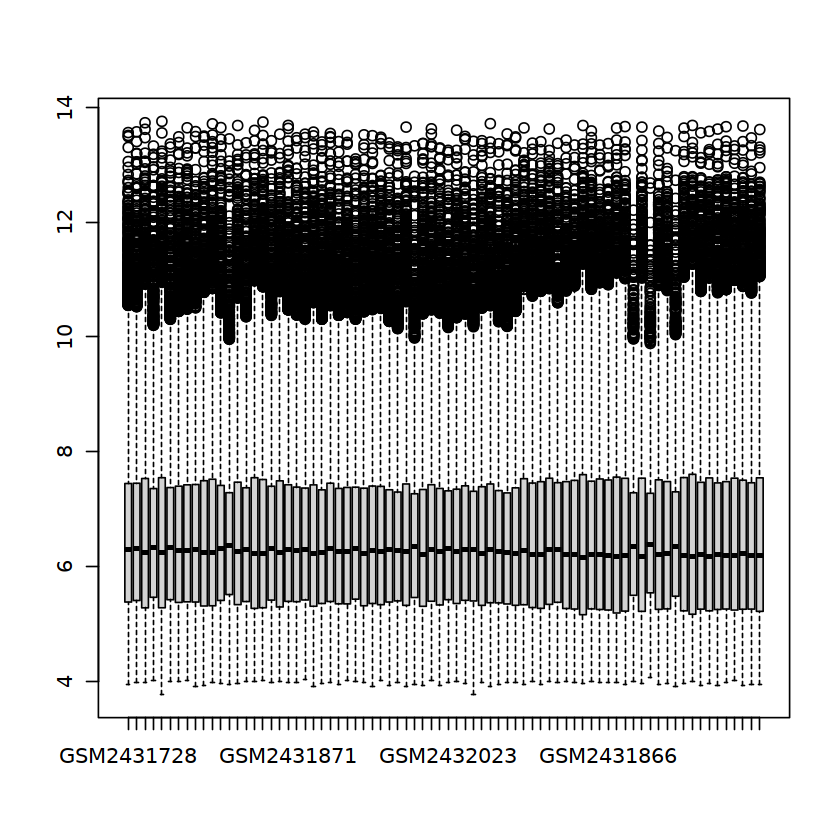

In [59]:
boxplot(expr1)

In [60]:
death2 = ifelse(death == 1,'yes','no')

In [61]:
library(limma)
library(dplyr)
f <- death2 %>% as.factor()

In [62]:

desigN <- model.matrix(~ 0 + f)
colnames(desigN) <- levels(f)
fit = lmFit(expr1, desigN)
contrast.matrix <- makeContrasts(yes - no, levels = colnames(coef(fit)))
contrast.matrix 

,yes - no
no,-1
yes,1


In [63]:
fit2 <- contrasts.fit(fit, contrast.matrix) 
fit2 <- eBayes(fit2) 
tempOutput <- topTable(fit2,coef=1,n=Inf,adjust="BH")
head(tempOutput)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
TREX1,-0.2346386,7.623454,-5.178929,1.742231e-06,0.02066112,4.2340349
TST,-0.2898071,7.409470,-4.525155,2.165835e-05,0.12467131,2.2022005
XPNPEP3,-0.1578134,6.149585,-4.423826,3.153840e-05,0.12467131,1.8991406
DBN1,0.2151558,7.881760,4.062109,1.162732e-04,0.19829612,0.8480450
RND1,0.3693857,7.656732,4.017076,1.362006e-04,0.19829612,0.7207941
WDR45,0.2764107,7.354555,3.911155,1.968191e-04,0.19829612,0.4248606


In [64]:
gene1 = tempOutput %>% filter(P.Value	 < 0.05) %>%  rownames()

In [66]:
diff <- 
  tempOutput %>% 
  mutate(change = as.factor(ifelse(P.Value	 < 0.05 & abs(logFC) > 0.2,
                                   ifelse(logFC > 0.2 ,'Up','Down'),'NOT'))) 
diff$gene = rownames(diff)

In [67]:
table(diff$change)


 Down   NOT    Up 
  239 11027   593 

In [68]:
library(ggplot2)
library(ggpubr)
library(ggrepel)
library(cowplot)

In [69]:
#diff[c('MUS81','UCK2','CNIH3','OTUD4'),]

In [70]:
top_5 <- bind_rows(   
      diff %>%
        filter(gene  %in% c('CNIH3','OTUD4')) %>%
        arrange(P.Value, desc(logFC)) %>%
        head(0),
      diff %>%
        filter(gene  %in% c('MUS81','UCK2')) %>%
        arrange(P.Value, desc(logFC)) %>%
        head(0)
    )

Warning message:
"Removed 3 rows containing missing values or values outside the scale range
(`geom_point()`)."


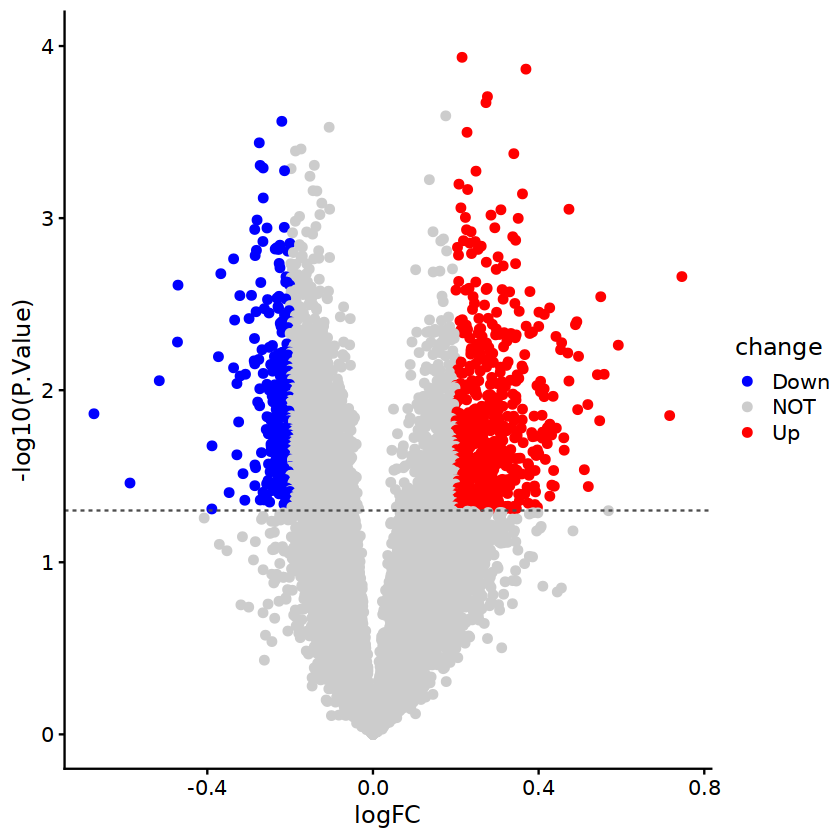

In [71]:

    ggplot(data=diff,aes(x=logFC,y=-log10(P.Value)))+
    geom_point(aes(color=change),size=2)+
    geom_hline(yintercept = -log10(0.05), linetype="dashed",color="grey30")+
    #geom_vline(xintercept = c(-0.3,0.3),linetype="dashed",color="grey30")+
    geom_text_repel(data=top_5,aes(x= logFC,y= -log10(P.Value),label= rownames(top_5)))+
    scale_color_manual(values = c("blue","grey80","red"))+
    theme_half_open() +ylim(0,4)#+xlim(-1.5,1.5)
    #ggsave('Volcano.pdf',height = 8,width = 8)

In [72]:
save(gene1,file = 'zhisha.gene.rda')

In [89]:
tempOutput1 = tempOutput %>%  dplyr::filter(P.Value < 0.05 & abs(logFC) > 0.2)

write.csv(tempOutput1,file = 'diffgene1.csv')

In [90]:
dim(tempOutput1)

[1] 832   6

In [91]:
matrix = cbind(death2,expr)

In [92]:
write.csv(matrix,file = 'Suicide.matrix.csv')